In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

!ln -s /content/gdrive/ /mydrive

Mounted at /content/gdrive


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8794801281375182598
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13459167707280271931
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [3]:
!pip -q install timm

     |████████████████████████████████| 376 kB 5.2 MB/s 


In [4]:
from __future__ import print_function

import glob
from itertools import chain
import time
import os
import random
import zipfile
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

import timm

%config InlineBackend.figure_format = 'retina'

In [5]:
print(f"Torch: {torch.__version__}")

Torch: 1.10.0+cu111


In [6]:
# Training settings
batch_size = 32
epochs = 30
lr = 3e-5
gamma = 0.7
seed = 42

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [8]:
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225] )
    ])

In [9]:
import torchvision
from torchvision.transforms import ToTensor

full_data = torchvision.datasets.ImageFolder('/content/gdrive/MyDrive/Dataset/COVID-CT-Dataset_augmented', transform=TRANSFORM_IMG)
train_data, test_data, valid_data = torch.utils.data.random_split(full_data, [2984, 373, 373])

In [10]:
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np

train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader  = data.DataLoader(test_data, batch_size=batch_size, shuffle=True) 

In [11]:
print(len(full_data))
print(len(train_data), len(train_loader))
print(len(valid_data), len(valid_loader))
print(len(test_data), len(test_loader))

3730
2984 94
373 12
373 12


In [12]:
from pprint import pprint
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['adv_inception_v3',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'cspdarknet53',
 'cspresnet50',
 'cspresnext50',
 'deit_base_distilled_patch16_224',
 'deit_base_distilled_patch16_384',
 'deit_base_patch16_224',
 'deit_base_patch16_384',
 'deit_small_distilled_patch16_224',
 'deit_small_patch16_224',
 'deit_tiny_distilled_patch16_224',
 'deit_tiny_patch16_224',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2next',
 'dla60x',
 'dla60x_c',
 'dla102',
 'dla102x',
 'dla102x2',
 'dla169',
 'dm_nfnet_f0',
 'dm_nfnet_f1',
 'dm_nfnet_f2',
 'dm_nfnet_f3',
 'dm_nfnet_f4',
 'dm_nfnet_f5',
 'dm_nfnet_f6',
 'dpn68',
 'dpn

## Effecient Attention

### Visual Transformer

In [13]:
device = 'cuda'

model = timm.create_model('xception', pretrained=True, num_classes=2).to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


### Training

In [14]:
model

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

In [15]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

n_epochs_stop = 3

min_val_loss = 10

In [16]:
epoch_l = []
loss_l = []
acc_l = []
v_loss_l = []
v_acc_l = []

In [17]:
since = time.time()
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
        
        epoch_l.append(epoch+1)
        loss_l.append(epoch_loss)
        acc_l.append(epoch_accuracy)
        v_loss_l.append(epoch_val_loss)
        v_acc_l.append(epoch_val_accuracy)
        
        print(f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n")
        
        if epoch_val_loss < min_val_loss:
            #Saving the model
            best_model = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            min_val_loss = epoch_val_loss
            early_stoped = False

        else:
            epochs_no_improve += 1
            # Check early stopping condition
            if epochs_no_improve == n_epochs_stop:
                print('Early stopping!' )
                model.load_state_dict(best_model)
                early_stoped = True
                break
    if early_stoped:
        break

elapsed_time = time.time() - since
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.5984 - acc: 0.6998 - val_loss : 0.4865 - val_acc: 0.8084



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.3499 - acc: 0.8630 - val_loss : 0.3437 - val_acc: 0.8436



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.1810 - acc: 0.9365 - val_loss : 0.2888 - val_acc: 0.8671



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0833 - acc: 0.9804 - val_loss : 0.2989 - val_acc: 0.8616



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0478 - acc: 0.9897 - val_loss : 0.2851 - val_acc: 0.8828



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.0348 - acc: 0.9914 - val_loss : 0.2488 - val_acc: 0.8867



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.0161 - acc: 0.9980 - val_loss : 0.3010 - val_acc: 0.8839



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.0115 - acc: 0.9987 - val_loss : 0.3064 - val_acc: 0.8801



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.0141 - acc: 0.9977 - val_loss : 0.2987 - val_acc: 0.8867

Early stopping!
Training completed in 27m 53s


In [18]:
torch.save(model, './xception_model_pretrained.pt')

# Testing

In [19]:
since = time.time()

y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

def flatten(new:list, target:list):
    for li in target:
        for value in list(li):
            new.append(value)

y_pred = []
y_true = []
flatten(y_pred, y_pred_list)
flatten(y_true, y_true_list)

elapsed_time = time.time() - since
print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

  0%|          | 0/12 [00:00<?, ?it/s]

Evaluation completed in 0m 38s


In [20]:
from sklearn.metrics import accuracy_score, f1_score, log_loss
print("Overall accuracy:", accuracy_score(y_true, y_pred))
print("Overall F1:", f1_score(y_true, y_pred, average='weighted'))
print("Overall Loss:", log_loss(y_true, y_pred))

Overall accuracy: 0.903485254691689
Overall F1: 0.903485254691689
Overall Loss: 3.333539793486671


In [21]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_true, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.89714286 0.90909091]
recall: [0.89714286 0.90909091]
fscore: [0.89714286 0.90909091]
support: [175 198]


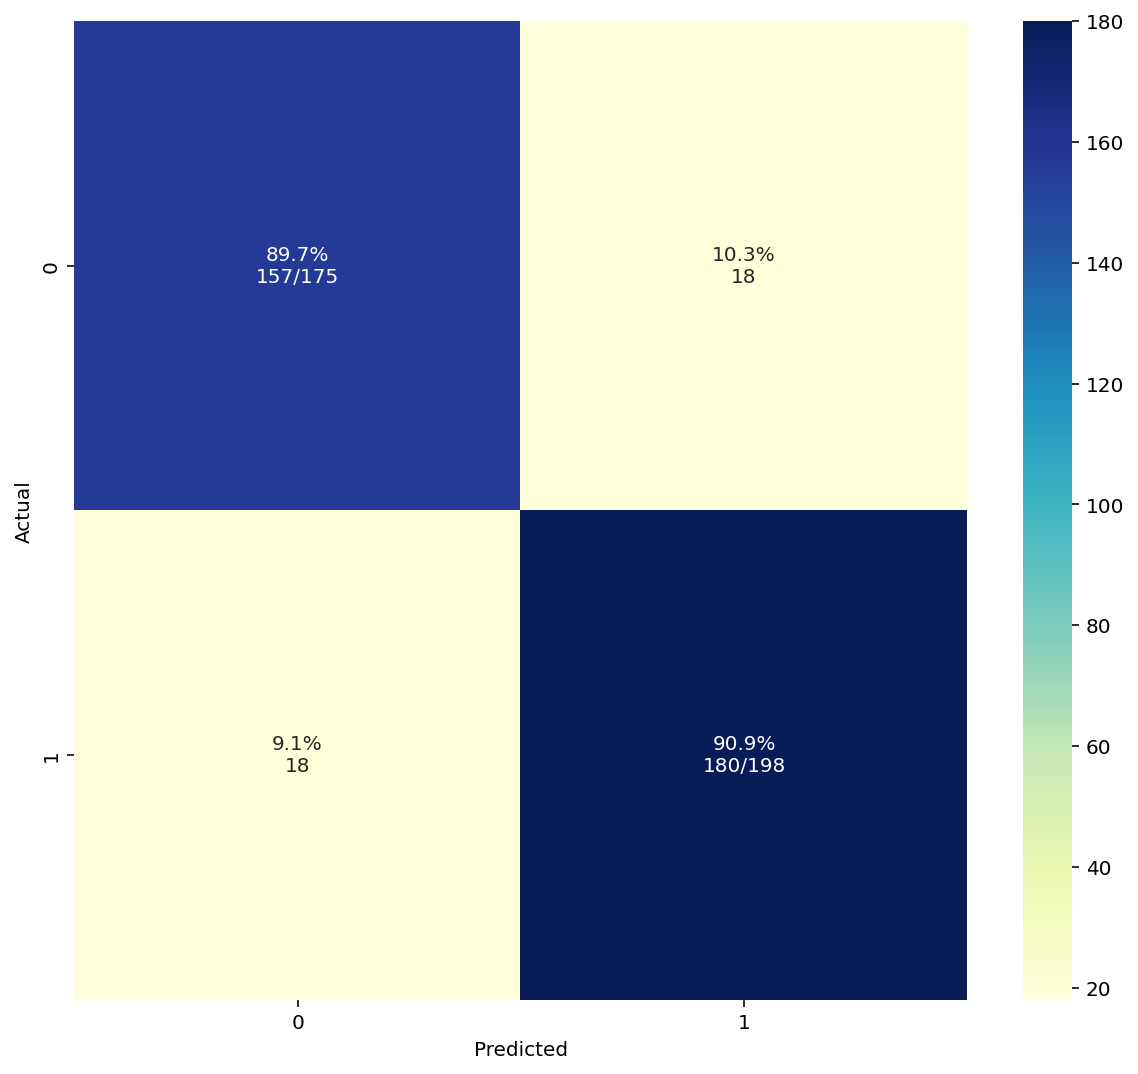

In [22]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns

def plot_cm(y_true, y_pred, figsize=(10,9)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

plot_cm(y_true, y_pred)

display()

In [23]:
loss_l_c = []
acc_l_c = []
v_loss_l_c = []
v_acc_l_c = []
for x in loss_l:
    x = x.cpu().detach().numpy()
    loss_l_c.append(x)
for x in acc_l:
    x = x.cpu().detach().numpy()
    acc_l_c.append(x)
for x in v_loss_l:
    x = x.cpu().detach().numpy()
    v_loss_l_c.append(x)
for x in v_acc_l:
    x = x.cpu().detach().numpy()
    v_acc_l_c.append(x)

In [24]:
import plotly.graph_objects as go

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=epoch_l, y=loss_l_c,
                    mode='lines+markers',
                    name='Train loss'))
fig.add_trace(go.Scatter(x=epoch_l, y=acc_l_c,
                    mode='lines+markers',
                    name='Train accuracy'))
fig.add_trace(go.Scatter(x=epoch_l, y=v_loss_l_c,
                    mode='lines+markers',
                    name='Validation loss'))
fig.add_trace(go.Scatter(x=epoch_l, y=v_acc_l_c,
                    mode='lines+markers',
                    name='Validation accuracy'))
fig.update_layout(
    title='ViT(pre-trained)',
    autosize=False,
    width=1000,
    height=600,
)

fig.show()

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model=torch.load('/content/gdrive/MyDrive/Experiments/ConVit/convit_model_pretrained_2.pt')  # Load from drive, not from above, skip this cell if load from above
# model.eval()

COVID-19 Negative


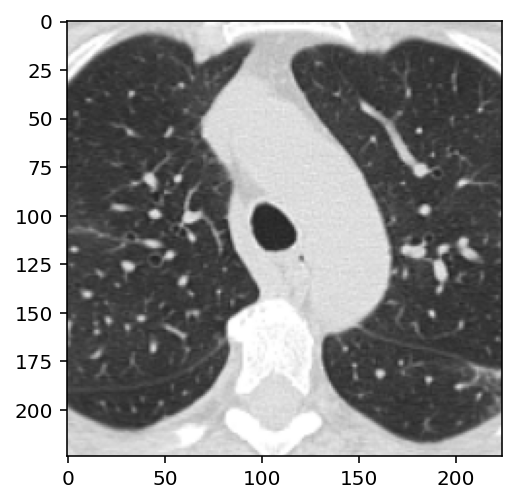

In [25]:
with torch.no_grad():
  def image_loader(image_name):
      """load image, returns cuda tensor"""
      image = Image.open(image_name)
      image = TRANSFORM_IMG(image).float()
      image = Variable(image, requires_grad=True)
      image1 = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
      return image1.cuda(), image  #assumes that you're using GPU

  image1, image2 = image_loader("/content/gdrive/MyDrive/Dataset/COVID-19_PN_Dataset/validation/COVID/Covid (1).png")

plt.imshow(image2.detach().permute(1, 2, 0))
output = model(image1)
if output[0][0] > output[0][1]:
    print("COVID-19 Positive")
else:
    print("COVID-19 Negative")

COVID-19 Negative


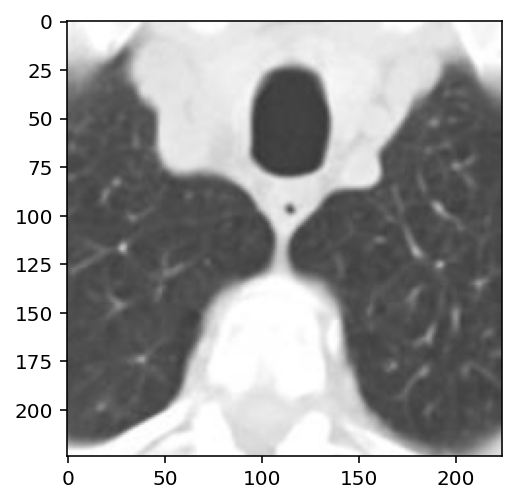

In [26]:
image1, image2 = image_loader("/content/Non-Covid (1) copy.png")  # Non-COVID images in the dataset contain Alpha channel (needs to be removed).

plt.imshow(image2.detach().permute(1, 2, 0))
output = model(image1)
if output[0][0] > output[0][1]:
    print("COVID-19 Positive")
else:
    print("COVID-19 Negative")

In [27]:
def predict_image(image):
    image_tensor = TRANSFORM_IMG(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [28]:
classes = ['Positive', 'Negative']
def get_random_images(num):
    # classes = test_data.classes
    indices = list(range(len(test_data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(test_data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

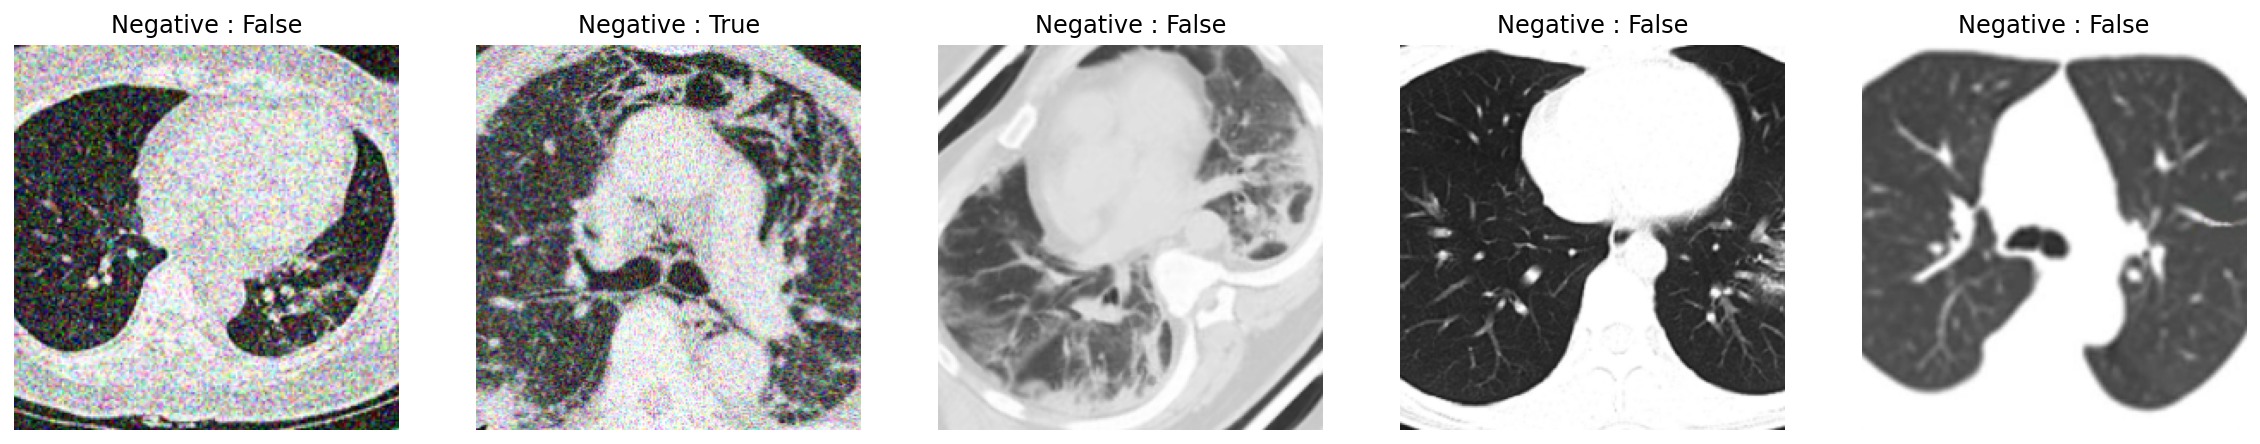

In [29]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(20,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + " : " + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

# Validate with another dataset

In [30]:
import torch.utils.data as data
data_dir_2 = '/content/gdrive/MyDrive/Dataset/COVID-19_PN_Dataset/full'
test_data_2 = torchvision.datasets.ImageFolder(data_dir_2, transform=TRANSFORM_IMG)
test_loader_2  = data.DataLoader(test_data_2, batch_size=batch_size, shuffle=True) 

In [31]:
since = time.time()

y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader_2):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

def flatten(new:list, target:list):
    for li in target:
        for value in list(li):
            new.append(value)

y_pred = []
y_true = []
flatten(y_pred, y_pred_list)
flatten(y_true, y_true_list)

elapsed_time = time.time() - since
print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

  0%|          | 0/78 [00:00<?, ?it/s]

Evaluation completed in 4m 14s


In [32]:
from sklearn.metrics import accuracy_score, f1_score, log_loss
print("Overall accuracy:", accuracy_score(y_true, y_pred))
print("Overall F1:", f1_score(y_true, y_pred, average='weighted'))
print("Overall Loss:", log_loss(y_true, y_pred))

Overall accuracy: 0.5461507456670698
Overall F1: 0.5437471254077835
Overall Loss: 15.675610300433664


In [33]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_true, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.55943396 0.53624208]
recall: [0.47364217 0.62001627]
fscore: [0.51297578 0.57509434]
support: [1252 1229]


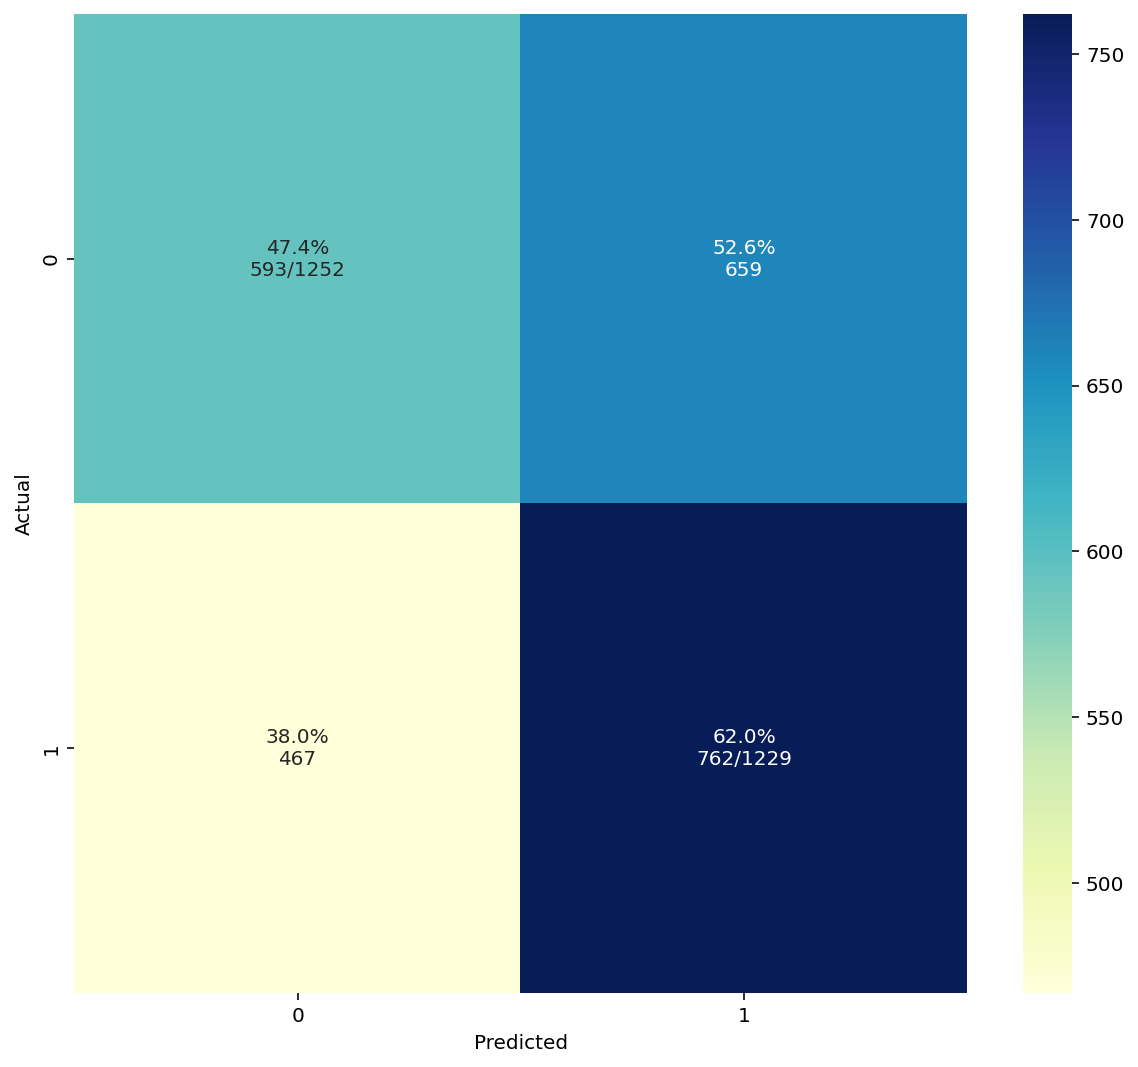

In [34]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns

def plot_cm(y_true, y_pred, figsize=(10,9)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

plot_cm(y_true, y_pred)

display()